In [3]:
import os
import random
import shutil
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from google.colab import drive

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Definir rutas
train_dir = '/content/drive/MyDrive/DCD-deeplearning/seg_train/seg_train'
test_dir = '/content/drive/MyDrive/DCD-deeplearning/seg_test/seg_test'
selected_train_dir = '/content/drive/MyDrive/DCD-deeplearning/selected_train'
selected_test_dir = '/content/drive/MyDrive/DCD-deeplearning/selected_test'


In [6]:
# Crear carpetas seleccionadas
os.makedirs(selected_train_dir, exist_ok=True)
os.makedirs(selected_test_dir, exist_ok=True)

# Ver clases disponibles
print("Clases en seg_train:", os.listdir(train_dir))
print("Clases en seg_test:", os.listdir(test_dir))


Clases en seg_train: ['forest', 'street', 'mountain', 'buildings', 'sea', 'glacier']
Clases en seg_test: ['street', 'glacier', 'buildings', 'forest', 'mountain', 'sea']


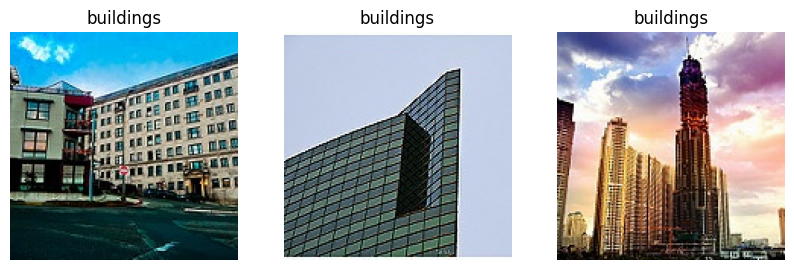

In [8]:
# Visualizar algunas imágenes de una clase
sample_class = 'buildings'
sample_class_path = os.path.join(train_dir, sample_class)

plt.figure(figsize=(10, 10))
for i, img_name in enumerate(os.listdir(sample_class_path)[:3]):
    img_path = os.path.join(sample_class_path, img_name)
    img = mpimg.imread(img_path)
    plt.subplot(1, 3, i + 1)
    plt.imshow(img)
    plt.title(sample_class)
    plt.axis('off')
plt.show()

In [9]:
# Seleccionar imágenes
num_images_train = 7000
num_images_test = 1500

def select_images(src_dir, dst_dir, num_images):
    classes = os.listdir(src_dir)
    images_per_class = num_images // len(classes)
    for class_name in classes:
        class_src = os.path.join(src_dir, class_name)
        class_dst = os.path.join(dst_dir, class_name)
        os.makedirs(class_dst, exist_ok=True)
        selected_images = random.sample(os.listdir(class_src), images_per_class)
        for img_name in selected_images:
            shutil.copy(os.path.join(class_src, img_name), os.path.join(class_dst, img_name))

select_images(train_dir, selected_train_dir, num_images_train)
select_images(test_dir, selected_test_dir, num_images_test)


In [10]:
# Generadores de datos
img_height, img_width = 64, 64
batch_size = 64

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    selected_train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    selected_test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 6996 images belonging to 6 classes.
Found 1500 images belonging to 6 classes.


In [11]:
# Aplicar filtro Sobel
def apply_sobel(image):
    gray = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    sobel = np.sqrt(sobelx**2 + sobely**2)
    sobel = cv2.normalize(sobel, None, 0, 1, cv2.NORM_MINMAX)
    sobel = np.repeat(np.expand_dims(sobel, axis=-1), 3, axis=-1)
    return sobel

class SobelGenerator(Sequence):
    def __init__(self, generator):
        self.generator = generator

    def __len__(self):
        return len(self.generator)

    def __getitem__(self, index):
        x_batch, y_batch = self.generator[index]
        sobel_batch = np.array([apply_sobel(img) for img in x_batch])
        return sobel_batch, y_batch

sobel_train_generator = SobelGenerator(train_generator)
sobel_test_generator = SobelGenerator(test_generator)


In [12]:
# Definir modelo CNN
def create_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(6, activation='softmax')
    ])
    return model

In [13]:
model = create_model()
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 683,974 (2.61 MB)

 Trainable params: 683,974 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Callbacks
model_save_path_adam = '/content/drive/MyDrive/DCD-deeplearning/best_model_adam.h5'
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint_adam = ModelCheckpoint(model_save_path_adam, save_best_only=True, monitor='val_loss')


In [15]:
# Entrenar con Adam
history_adam = model.fit(
    sobel_train_generator,
    epochs=10,
    validation_data=sobel_test_generator,
    callbacks=[early_stopping, checkpoint_adam]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.3662 - loss: 1.5080

110/110 ━━━━━━━━━━━━━━━━━━━━ 35s 274ms/step - accuracy: 0.3670 - loss: 1.5062 - val_accuracy: 0.5133 - val_loss: 1.1763
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.5772 - loss: 1.0612

110/110 ━━━━━━━━━━━━━━━━━━━━ 28s 251ms/step - accuracy: 0.5773 - loss: 1.0608 - val_accuracy: 0.6020 - val_loss: 0.9802
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.6484 - loss: 0.8879

110/110 ━━━━━━━━━━━━━━━━━━━━ 27s 250ms/step - accuracy: 0.6483 - loss: 0.8879 - val_accuracy: 0.6393 - val_loss: 0.9502
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.6901 - loss: 0.7863

110/110 ━━━━━━━━━━━━━━━━━━━━ 27s 250ms/step - accuracy: 0.6900 - loss: 0.7864 - val_accuracy: 0.6573 - val_loss: 0.8719
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.7328 - loss: 0.6943

110/110 ━━━━━━━━━━━━━━━━━━━━ 27s 246ms/step - accuracy: 0.7327 - loss: 0.6944 - val_accuracy: 0.6687 - val_loss: 0.8465
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 27s 244ms/step - accuracy: 0.7628 - loss: 0.6229 - val_accuracy: 0.6800 - val_loss: 0.8575
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.7880 - loss: 0.5475

110/110 ━━━━━━━━━━━━━━━━━━━━ 28s 253ms/step - accuracy: 0.7879 - loss: 0.5475 - val_accuracy: 0.7033 - val_loss: 0.8360
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 27s 244ms/step - accuracy: 0.8329 - loss: 0.4662 - val_accuracy: 0.7053 - val_loss: 0.8364
Epoch 9/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 27s 244ms/step - accuracy: 0.8504 - loss: 0.4025 - val_accuracy: 0.6993 - val_loss: 0.8787
Epoch 10/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 27s 247ms/step - accuracy: 0.8894 - loss: 0.3220 - val_accuracy: 0.6600 - val_loss: 1.1059


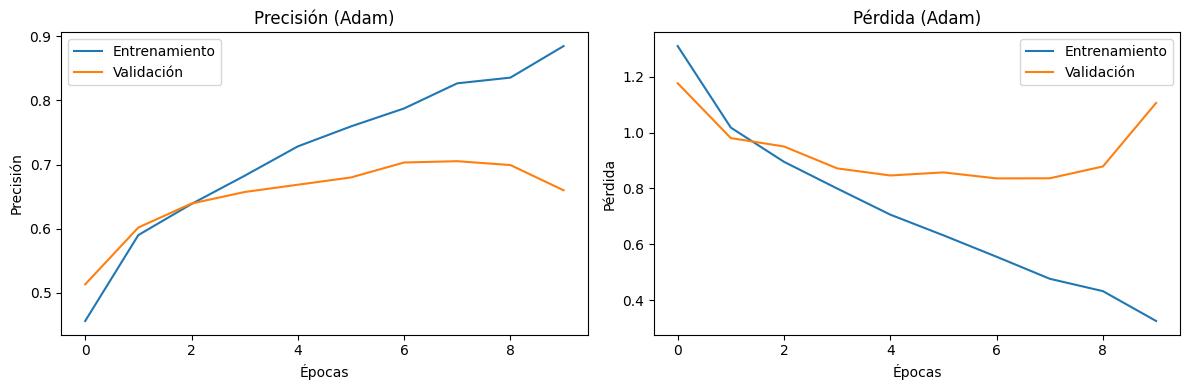

In [16]:
# Gráficas de entrenamiento (Adam)
def plot_history(history, title_suffix=''):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Validación')
    plt.title(f'Precisión {title_suffix}')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Entrenamiento')
    plt.plot(history.history['val_loss'], label='Validación')
    plt.title(f'Pérdida {title_suffix}')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history_adam, title_suffix='(Adam)')


In [17]:
# Cambiar optimizador a SGD
model.compile(optimizer=SGD(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
model_save_path_sgd = '/content/drive/MyDrive/DCD-deeplearning/best_model_sgd.h5'
checkpoint_sgd = ModelCheckpoint(model_save_path_sgd, save_best_only=True, monitor='val_loss')


Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.6954 - loss: 0.9657

110/110 ━━━━━━━━━━━━━━━━━━━━ 29s 252ms/step - accuracy: 0.6959 - loss: 0.9635 - val_accuracy: 0.6467 - val_loss: 0.9862
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.8004 - loss: 0.5441

110/110 ━━━━━━━━━━━━━━━━━━━━ 27s 246ms/step - accuracy: 0.8005 - loss: 0.5440 - val_accuracy: 0.6740 - val_loss: 0.9601
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 27s 242ms/step - accuracy: 0.8206 - loss: 0.4836 - val_accuracy: 0.6427 - val_loss: 1.0350
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.8300 - loss: 0.4754

110/110 ━━━━━━━━━━━━━━━━━━━━ 27s 245ms/step - accuracy: 0.8300 - loss: 0.4754 - val_accuracy: 0.6807 - val_loss: 0.9238
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 26s 240ms/step - accuracy: 0.8332 - loss: 0.4458 - val_accuracy: 0.6833 - val_loss: 0.9334
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 27s 241ms/step - accuracy: 0.8517 - loss: 0.4228 - val_accuracy: 0.6867 - val_loss: 0.9478
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 41s 240ms/step - accuracy: 0.8489 - loss: 0.4249 - val_accuracy: 0.6720 - val_loss: 0.9847


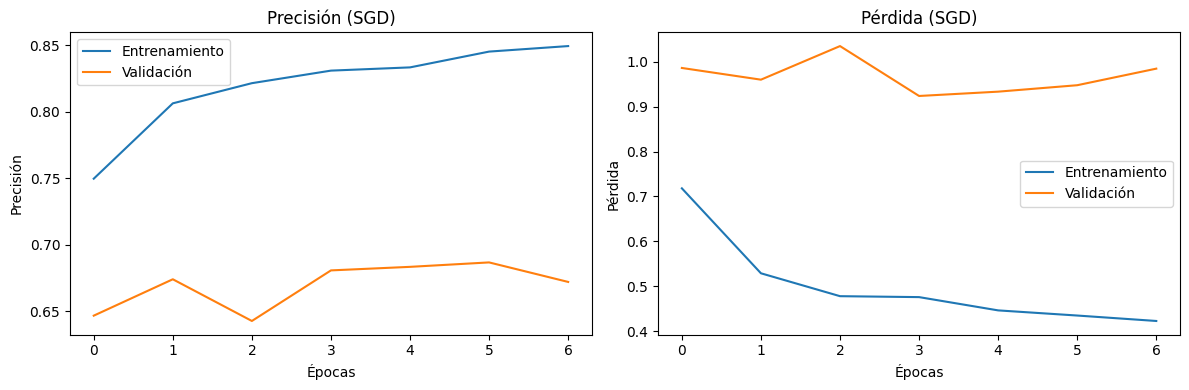

In [18]:
# Entrenar con SGD
history_sgd = model.fit(
    sobel_train_generator,
    epochs=10,
    validation_data=sobel_test_generator,
    callbacks=[early_stopping, checkpoint_sgd]
)

plot_history(history_sgd, title_suffix='(SGD)')


In [19]:
# Evaluación
def evaluate_model(model, generator, title):
    loss, acc = model.evaluate(generator)
    print(f'{title} - Pérdida: {loss:.4f}, Precisión: {acc:.4f}')

evaluate_model(model, sobel_test_generator, 'Evaluación final (SGD)')


24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 209ms/step - accuracy: 0.6741 - loss: 0.9506
Evaluación final (SGD) - Pérdida: 0.9238, Precisión: 0.6807


In [20]:
# Matrices de confusión
def plot_confusion_matrix(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicción')
    plt.ylabel('Verdadero')
    plt.title(title)
    plt.show()

24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 208ms/step


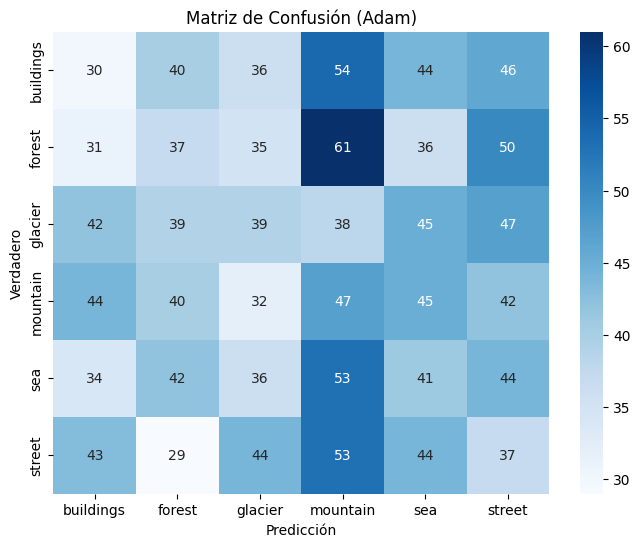

In [21]:
# Para Adam
model.load_weights(model_save_path_adam)
y_pred_adam = np.argmax(model.predict(sobel_test_generator), axis=1)
y_true = sobel_test_generator.generator.classes
plot_confusion_matrix(y_true, y_pred_adam, list(sobel_test_generator.generator.class_indices.keys()), 'Matriz de Confusión (Adam)')


24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 193ms/step


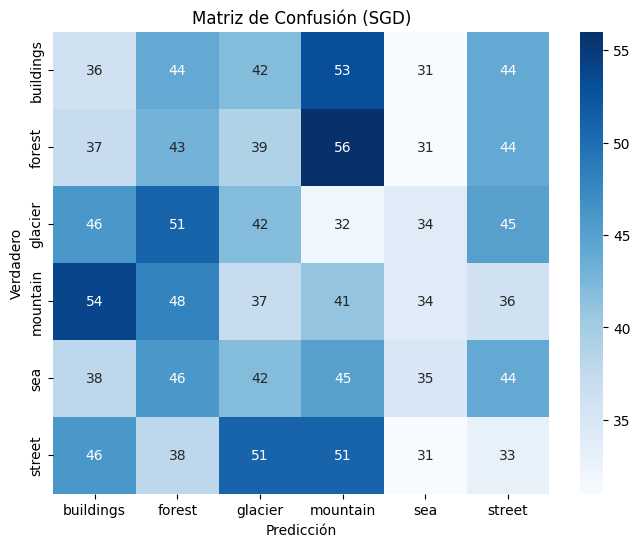

In [22]:
# Para SGD
model.load_weights(model_save_path_sgd)
y_pred_sgd = np.argmax(model.predict(sobel_test_generator), axis=1)
plot_confusion_matrix(y_true, y_pred_sgd, list(sobel_test_generator.generator.class_indices.keys()), 'Matriz de Confusión (SGD)')